In [24]:
import math

import pandas
import numpy
import matplotlib.pyplot as plt



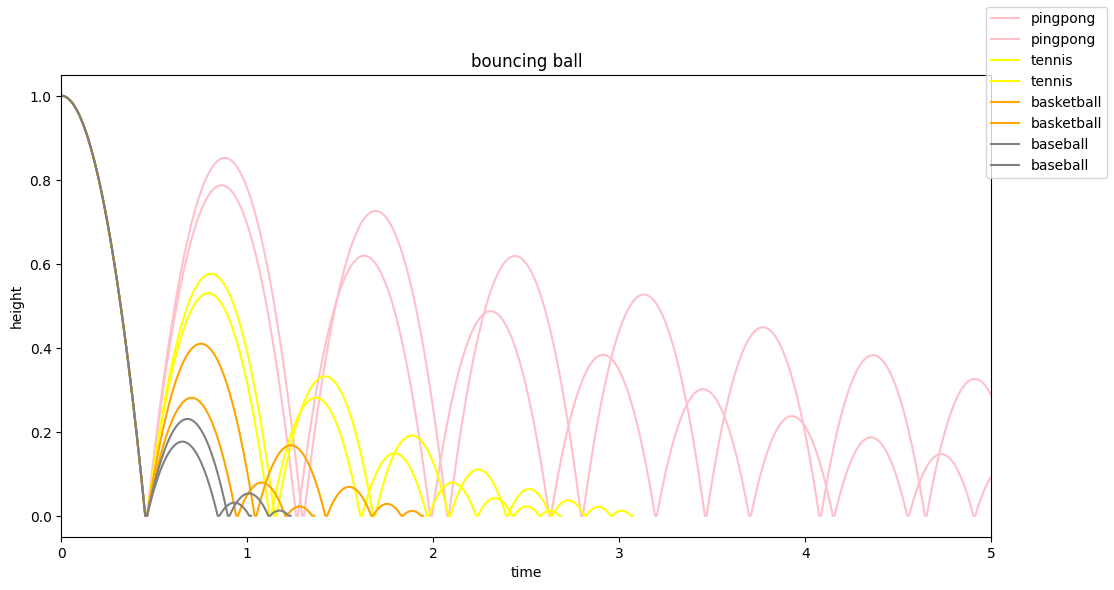

In [25]:


def simulate_bounce(rho=0.75,
                    dt=0.001,
                    g=9.81,
                    hstop = 0.01,
                    tau=0.01, # contact time for bounce
                   h0=1.0):
    # https://physics.stackexchange.com/a/333436

    sqrt = math.sqrt
    
    v = 0          # m/s, current velocity
    t = 0          # starting time
    hmax = h0      # keep track of the maximum height
    
    h = h0
    
    freefall = True # state: freefall or in contact
    t_last = -sqrt(2*h0/g) # time we would have launched to get to h0 at t=0
    vmax = sqrt(2 * hmax * g)
    H = []
    T = []
    while(hmax > hstop):
      if(freefall):
        hnew = h + v*dt - 0.5*g*dt*dt
        if(hnew<0):
          t = t_last + 2*sqrt(2*hmax/g)
          freefall = False
          t_last = t + tau
          h = 0
        else:
          t = t + dt
          v = v - g*dt
          h = hnew
      else:
        t = t + tau
        vmax = vmax * rho
        v = vmax
        freefall = True
        h = 0
      hmax = 0.5*vmax*vmax/g
      H.append(h)
      T.append(t)

    return T, H


def plot_bounce(ax, T, H, label=None, color=None):

    ax.plot(T, H, label=label, color=color)
    ax.set_xlabel('time')
    ax.set_ylabel('height')
    ax.set_title('bouncing ball')



# coefficients of restitution
balls = {
    'pingpong': (0.887, 0.923),
    'tennis': (0.728, 0.759),
    'basketball': (0.53, 0.64),
    'baseball': (0.42, 0.48), # around 0.45
}

colors = {
    'pingpong': 'pink',
    'tennis': 'yellow',
    'basketball': 'orange',
    'baseball': 'grey'
}

fig, ax = plt.subplots(1, figsize=(12, 6))
for name, (cor_low, cor_high) in balls.items():

    c = colors[name]
    for rho in (cor_low, cor_high):
        T, H = simulate_bounce(rho=rho)
        plot_bounce(ax, T, H, label=name, color=c)

ax.set_xlim(0, 5)
fig.legend()

In [42]:

def merge_events(times, min_distance=0.01):
    # XXX: assumes that times are sorted, increasing order
    out = []
    previous_t = float('-inf')
    for t in times:
        dt = t - previous_t
        if dt >= min_distance:
            previous_t = t
            out.append(t)

    return numpy.array(out)

def extract_pairs(values):
    out = []

    for s, e in zip(values, values[1:]):
        out.append((s, e))

    o = numpy.stack(out)
    return o

def simulate_ball_bounce(rho):

    out = {
        'rho': rho,
    }

    # simulate over time
    T, H = simulate_bounce(rho=rho)

    df = pandas.DataFrame({
        'time': T,
        'height': H,
    }).set_index('time')

    out['timeline'] = df
    
    # find points where ball touches the ground / bounces
    touching = df[df.height == 0]
    m = merge_events(touching.index, min_distance=0.1)
    out['touch_times'] = m
    
    # compute time between consecutive bounces
    deltas = numpy.diff(m)
    p = extract_pairs(deltas)
    out['bounce_pairs'] = p 

    return out


def simulate_balls():

    data = []
    for name, (cor_low, cor_high) in balls.items():
    
        c = colors[name]
        for rho in (cor_low, cor_high):
            out = simulate_ball_bounce(rho=rho)
            out['ball'] = name
            data.append(out)

    df = pandas.DataFrame.from_records(data)
    return df

simulated = simulate_balls()
simulated

,rho,timeline,touch_times,bounce_pairs,ball
0,0.887,height time 0.001000...,"[0.4515236409857309, 1.2625265800944176, 1.983...","[[0.8110029391086868, 0.7204896069894051], [0....",pingpong
1,0.923,height time 0.0010...,"[0.4515236409857309, 1.2950362822453902, 2.074...","[[0.8435126412596594, 0.7793321678826657], [0....",pingpong
2,0.728,height time 0.001000...,"[0.4515236409857309, 1.1189420622609552, 1.607...","[[0.6674184212752243, 0.48860061068836314], [0...",tennis
3,0.759,height time 0.001000...,"[0.4515236409857309, 1.1469365280020705, 1.677...","[[0.6954128870163396, 0.5302283812454018], [0....",tennis
4,0.530,height time 0.001000...,"[0.4515236409857309, 0.9401387004306057, 1.203...","[[0.48861505944487477, 0.2636659815057836], [0...",basketball
5,0.640,height time 0.001000...,"[0.4515236409857309, 1.0394739014474665, 1.419...","[[0.5879502604617357, 0.37988816669551095], [0...",basketball
6,0.420,height time 0.001000...,"[0.4515236409857309, 0.8408034994137449, 1.010...","[[0.389279858428014, 0.16929754053976598]]",baseball
7,0.480,height time 0.001000...,"[0.4515236409857309, 0.8949863363320325, 1.113...","[[0.4434626953463016, 0.21806209376622476], [0...",baseball


In [49]:

def extract_bounce_pairs(sim):

    out = []
    for idx, row in simulated.iterrows():
        rho = row['rho']
        for p in row['bounce_pairs']:
            d = {
                'rho': rho,
                'dt1': p[0],
                'dt2': p[1],
            }
            out.append(d)
    
    df = pandas.DataFrame.from_records(out)
    return df

pairs = extract_bounce_pairs(simulated)
pairs


,rho,dt1,dt2
0,0.887,0.811003,0.720490
1,0.887,0.720490,0.640204
2,0.887,0.640204,0.568991
3,0.887,0.568991,0.505825
4,0.887,0.505825,0.449797
...,...,...,...
62,0.640,0.246728,0.161506
63,0.640,0.161506,0.106964
64,0.420,0.389280,0.169298
65,0.480,0.443463,0.218062


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


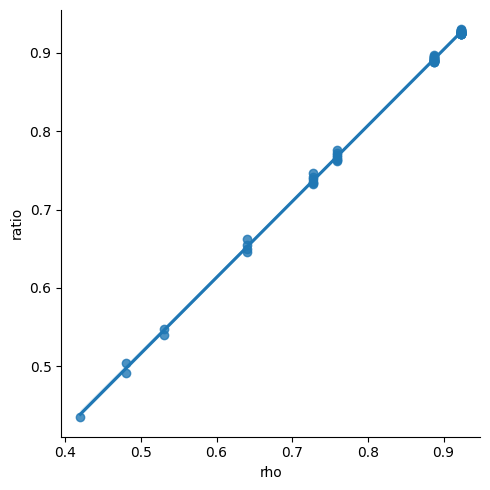

In [52]:
import seaborn

pairs['ratio'] = pairs.dt2 / pairs.dt1 
seaborn.lmplot(data=pairs, x='rho', y='ratio')